<a href="https://colab.research.google.com/github/btcnhung1299/tf-practice/blob/master/TXT_SarcasmDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

## Data Gathering

In [2]:
!wget https://storage.googleapis.com/laurencemoroney-blog.appspot.com/sarcasm.json

--2020-09-27 10:34:42--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/sarcasm.json
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.24.128, 172.217.194.128, 2404:6800:4003:c04::80
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.24.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5643545 (5.4M) [application/json]
Saving to: ‘sarcasm.json’

sarcasm.json        100%[===================>]   5.38M  --.-KB/s    in 0.05s   

2020-09-27 10:34:43 (109 MB/s) - ‘sarcasm.json’ saved [5643545/5643545]



In [3]:
df = pd.read_json("./sarcasm.json")
df.head()

,article_link,headline,is_sarcastic
0,https://www.huffingtonpost.com/entry/versace-b...,former versace store clerk sues over secret 'b...,0
1,https://www.huffingtonpost.com/entry/roseanne-...,the 'roseanne' revival catches up to our thorn...,0
2,https://local.theonion.com/mom-starting-to-fea...,mom starting to fear son's web series closest ...,1
3,https://politics.theonion.com/boehner-just-wan...,"boehner just wants wife to listen, not come up...",1
4,https://www.huffingtonpost.com/entry/jk-rowlin...,j.k. rowling wishes snape happy birthday in th...,0


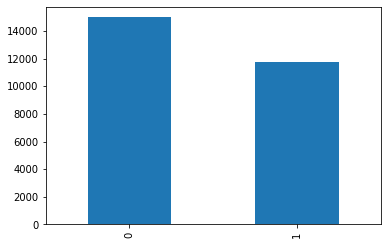

In [4]:
df["is_sarcastic"].value_counts().plot(kind="bar");

In [5]:
texts = df["headline"].values
labels = df["is_sarcastic"].values

## Data Preparation

### Tokenization

In [6]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [7]:
VOCAB_SIZE = 10000
tokenizer = Tokenizer(VOCAB_SIZE, oov_token="<OOV>")
tokenizer.fit_on_texts(texts)

### Create samples

In [8]:
df["headline"].apply(lambda x : len(x)).describe()

count    26709.000000
mean        60.910629
std         19.184423
min          7.000000
25%         48.000000
50%         61.000000
75%         73.000000
max        254.000000
Name: headline, dtype: float64

In [9]:
MAX_SEQ_LEN = 128
BUFFER_SIZE = 1024

text_ids = pad_sequences(tokenizer.texts_to_sequences(texts), maxlen=MAX_SEQ_LEN, padding="post")
samples = tf.data.Dataset.from_tensor_slices((text_ids, labels)).shuffle(BUFFER_SIZE)

### Create dataset

In [10]:
BATCH_SIZE = 64

test_size = 0.2
num_samples = sum(1 for x in samples)
num_train_samples = int((1 - test_size) * num_samples)
print("Number of training samples:", num_train_samples)
print("Number of validation samples:", num_samples - num_train_samples)
ds_train = samples.take(num_train_samples).batch(BATCH_SIZE)
ds_val = samples.skip(num_train_samples).batch(BATCH_SIZE)

Number of training samples: 21367
Number of validation samples: 5342


## Model Architecture

In [11]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dropout, GlobalAveragePooling1D, Dense

EMBED_DIM = 64

model = Sequential()
model.add(Embedding(input_dim=VOCAB_SIZE, output_dim=EMBED_DIM))
model.add(GlobalAveragePooling1D())
model.add(Dense(64, activation="swish"))
model.add(Dropout(0.3))
model.add(Dense(1, activation="sigmoid"))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 64)          640000    
_________________________________________________________________
global_average_pooling1d (Gl (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 64)                4160      
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 644,225
Trainable params: 644,225
Non-trainable params: 0
_________________________________________________________________


In [12]:
model.compile(optimizer="rmsprop", loss="binary_crossentropy", metrics=["acc"])

In [13]:
model.fit(ds_train, epochs=20, validation_data=ds_val);

Epoch 1/20
334/334 [==============================] - 2s 7ms/step - loss: 0.6727 - acc: 0.5687 - val_loss: 0.6264 - val_acc: 0.7583
Epoch 2/20
334/334 [==============================] - 2s 7ms/step - loss: 0.5114 - acc: 0.7805 - val_loss: 0.4456 - val_acc: 0.8021
Epoch 3/20
334/334 [==============================] - 2s 7ms/step - loss: 0.3792 - acc: 0.8367 - val_loss: 0.3728 - val_acc: 0.8403
Epoch 4/20
334/334 [==============================] - 2s 7ms/step - loss: 0.3327 - acc: 0.8591 - val_loss: 0.3512 - val_acc: 0.8547
Epoch 5/20
334/334 [==============================] - 2s 7ms/step - loss: 0.3045 - acc: 0.8717 - val_loss: 0.3444 - val_acc: 0.8562
Epoch 6/20
334/334 [==============================] - 2s 7ms/step - loss: 0.2819 - acc: 0.8829 - val_loss: 0.3418 - val_acc: 0.8560
Epoch 7/20
334/334 [==============================] - 2s 7ms/step - loss: 0.2681 - acc: 0.8888 - val_loss: 0.3557 - val_acc: 0.8493
Epoch 8/20
334/334 [==============================] - 2s 7ms/step - loss: 0.

In [14]:
model.evaluate(ds_val)

84/84 [==============================] - 0s 2ms/step - loss: 0.3700 - acc: 0.8560


[0.3700163662433624, 0.8560464382171631]

### RNN

In [15]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, GRU, Dropout, Dense, SpatialDropout1D

EMBED_DIM = 64

model = Sequential()
model.add(Embedding(input_dim=VOCAB_SIZE, output_dim=EMBED_DIM))
model.add(Bidirectional(GRU(64, return_sequences=True)))
model.add(Bidirectional(GRU(32)))
model.add(Dense(64, activation="swish"))
model.add(Dropout(0.4))
model.add(Dense(1, activation="sigmoid"))

In [16]:
model.compile(optimizer="rmsprop", loss="binary_crossentropy", metrics=["acc"])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 64)          640000    
_________________________________________________________________
bidirectional (Bidirectional (None, None, 128)         49920     
_________________________________________________________________
bidirectional_1 (Bidirection (None, 64)                31104     
_________________________________________________________________
dense_2 (Dense)              (None, 64)                4160      
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 65        
Total params: 725,249
Trainable params: 725,249
Non-trainable params: 0
________________________________________________

In [17]:
model.fit(ds_train, epochs=10, validation_data=ds_val);

Epoch 1/10
334/334 [==============================] - 12s 35ms/step - loss: 0.3905 - acc: 0.8148 - val_loss: 0.3266 - val_acc: 0.8602
Epoch 2/10
334/334 [==============================] - 11s 32ms/step - loss: 0.2498 - acc: 0.8961 - val_loss: 0.2964 - val_acc: 0.8721
Epoch 3/10
334/334 [==============================] - 10s 31ms/step - loss: 0.2043 - acc: 0.9185 - val_loss: 0.2915 - val_acc: 0.8748
Epoch 4/10
334/334 [==============================] - 10s 31ms/step - loss: 0.1734 - acc: 0.9325 - val_loss: 0.3074 - val_acc: 0.8735
Epoch 5/10
334/334 [==============================] - 10s 31ms/step - loss: 0.1475 - acc: 0.9440 - val_loss: 0.3058 - val_acc: 0.8744
Epoch 6/10
334/334 [==============================] - 10s 31ms/step - loss: 0.1271 - acc: 0.9534 - val_loss: 0.3152 - val_acc: 0.8763
Epoch 7/10
334/334 [==============================] - 10s 31ms/step - loss: 0.1101 - acc: 0.9604 - val_loss: 0.3214 - val_acc: 0.8787
Epoch 8/10
334/334 [==============================] - 10s 31ms

In [18]:
model.evaluate(ds_val)

84/84 [==============================] - 1s 11ms/step - loss: 0.3912 - acc: 0.8735


[0.39116621017456055, 0.8734556436538696]

### Transfer learning w. pretrained embedding

*Train and test set is not the same for each approach :(*

In [19]:
BATCH_SIZE = 32
BUFFER_SIZE = 1024

samples = tf.data.Dataset.from_tensor_slices((texts, labels)).shuffle(BUFFER_SIZE)
num_samples = sum(1 for x in samples)
test_size = 0.2
num_train_samples = int((1 - test_size) * num_samples)

ds_train = samples.take(num_train_samples).batch(BATCH_SIZE)
ds_val = samples.skip(num_train_samples).batch(BATCH_SIZE)

In [23]:
import tensorflow_hub as hub
embedding_url = "https://tfhub.dev/google/universal-sentence-encoder/4"

model = Sequential()
model.add(hub.KerasLayer(embedding_url, input_shape=(), dtype=tf.string, trainable=True))
model.add(Dense(64, activation="swish"))
model.add(Dropout(0.3))
model.add(Dense(1, activation="sigmoid"))
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_1 (KerasLayer)   (None, 512)               256797824 
_________________________________________________________________
dense_6 (Dense)              (None, 64)                32832     
_________________________________________________________________
dropout_3 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 65        
Total params: 256,830,721
Trainable params: 256,830,721
Non-trainable params: 0
_________________________________________________________________


In [24]:
model.compile(optimizer="rmsprop", loss="binary_crossentropy", metrics=["acc"])
model.fit(ds_train, epochs=4, validation_data=ds_val);

Epoch 1/4
668/668 [==============================] - 65s 97ms/step - loss: 0.3851 - acc: 0.8263 - val_loss: 0.2874 - val_acc: 0.8798
Epoch 2/4
668/668 [==============================] - 65s 97ms/step - loss: 0.2150 - acc: 0.9155 - val_loss: 0.2613 - val_acc: 0.8918
Epoch 3/4
668/668 [==============================] - 65s 98ms/step - loss: 0.1363 - acc: 0.9482 - val_loss: 0.2645 - val_acc: 0.8884
Epoch 4/4
668/668 [==============================] - 65s 97ms/step - loss: 0.0895 - acc: 0.9680 - val_loss: 0.2551 - val_acc: 0.8957


In [26]:
model.evaluate(ds_val)

167/167 [==============================] - 1s 8ms/step - loss: 0.2557 - acc: 0.8970


[0.255685418844223, 0.8970423340797424]